# Wildfire Detection False-Positive Rejection and Fire Risk

Background: I'm working at OroraTech GmbH (https://ororatech.com/), a young Munich-based company providing satellite-based wildfire detection and monitoring services. 

`Valentin Dornauer <valentin@unimplemented.org>`

Thanks to OroraTech for providing computational resources for this research!


## Aggregate confirmed fires (training data)

The EFFIS project provides a manually curated list of actual wildfires, along with coordinates and timespans. These fires are used as "true positives" for the ML model. They are provided as KML (XML-based format). These attributes are extracted and saved into the `confirmed=[]` list.

https://effis.jrc.ec.europa.eu/applications/fire-news/

In [53]:
!pip3 install fastkml requests
from fastkml import kml
import requests

Package `lxml` missing. Pretty print will be disabled


In [54]:
k = kml.KML()
ret = k.from_string(requests.get("http://unimplemented.org/~valentin/fires.kml").text.encode('utf-8'))
root = list(k.features())
folder = list(root[0].features())

In [55]:
import datetime
confirmed = []
for f in folder[0].features():
  #print(f)
  start = False
  end = False
  for e in f.extended_data.elements[0].data:
    if e["name"] == "StartDate":
      start = datetime.datetime.strptime(e["value"], '%d/%m/%Y')
    if e["name"] == "EndDate":
      end = datetime.datetime.strptime(e["value"], '%d/%m/%Y')
  duration = (end-start).days + 1
  #print("lat=%f lon=%f start=%s end=%s durations=%dd" % (f.geometry.y, f.geometry.x, start, end, duration))
  confirmed.append({
      "lat": f.geometry.y,
      "lon": f.geometry.x,
      "start": start,
      "duration": duration,
      "end": end
  })
confirmed[:2]

[{'lat': 40.1548666,
  'lon': 15.62756688,
  'start': datetime.datetime(2018, 11, 26, 0, 0),
  'duration': 2,
  'end': datetime.datetime(2018, 11, 27, 0, 0)},
 {'lat': 40.05362301,
  'lon': 15.35781179,
  'start': datetime.datetime(2018, 11, 22, 0, 0),
  'duration': 1,
  'end': datetime.datetime(2018, 11, 22, 0, 0)}]

# Import FIRMS events

NASA provides a hot spot product from three of their satellites (MODIS-AQUA, MODIS-TERRA and Suomi-NPP). These satellites carry infrared-based sensors which can be used to detect wildfires. These hotspots are provided as CSV on the NASA website.

To limit the amount of data, currently only data for 2018 and the EU region is used. 

https://firms.modaps.eosdis.nasa.gov/download/

Area of Interest: `POLYGON((35.29705 33.49591,20.76892 33.68388,13.33854 34.4395,5.66475 37.24806,-3.33463 35.42468,-13.6752 35.77723,-15.50407 46.13137,-14.90754 54.9731,-7.92903 63.7695,6.86012 67.51096,15.81302 71.28015,27.57649 72.13655,38.83294 70.43848,48.20104 70.15378,57.59657 69.997,51.79583 37.30234,35.29705 33.49591))`

In [56]:
from zipfile import ZipFile
from io import StringIO
from io import BytesIO
from urllib.request import urlopen

resp = urlopen('https://unimplemented.org/~valentin/DL_FIRE_M6_96138.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['fire_archive_M6_96138.json', 'Readme.txt']

In [57]:
import json
# takes around 4GB ram
modis_fires = json.loads(zipfile.read("fire_archive_M6_96138.json"))
zipfile.close()
# free some
zipfile = None
resp = None

In [58]:
# same for VIIRS fires (a lot more because of higher spatial resolution)

resp = urlopen('https://unimplemented.org/~valentin/DL_FIRE_V1_96139.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()
viirs_fires = json.loads(zipfile.read("fire_archive_V1_96139.json"))
zipfile.close()
zipfile = None
resp = None

unconfirmed = modis_fires + viirs_fires

In [59]:
import pandas as pd
df = pd.DataFrame(modis_fires + viirs_fires)
df

,latitude,longitude,acq_date,acq_time,instrument,confidence,scan,satellite,track,type,brightness,daynight,frp,bright_t31,version,bright_ti4,bright_ti5
0,42.71470,24.17460,2018-01-01,0026,MODIS,63,1.00,Aqua,1.00,2,305.0,N,12.1,271.2,6.2,NaN,NaN
1,43.52590,-5.73610,2018-01-01,0205,MODIS,80,1.60,Aqua,1.20,2,310.4,N,26.3,280.2,6.2,NaN,NaN
2,43.52410,-5.71690,2018-01-01,0205,MODIS,57,1.60,Aqua,1.20,2,303.8,N,18.1,279.8,6.2,NaN,NaN
3,37.50640,22.41810,2018-01-01,1131,MODIS,75,1.10,Aqua,1.00,0,314.2,D,15.6,286.5,6.2,NaN,NaN
4,37.64550,22.65040,2018-01-01,1131,MODIS,60,1.10,Aqua,1.00,0,304.9,D,8.0,288.6,6.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632588,36.01836,43.68176,2018-12-31,2347,VIIRS,n,0.44,N,0.63,0,NaN,NaN,2.0,NaN,1,310.6,273.5
632589,35.99747,43.76006,2018-12-31,2347,VIIRS,n,0.45,N,0.63,0,NaN,NaN,4.6,NaN,1,317.8,277.0
632590,35.99618,43.76345,2018-12-31,2347,VIIRS,n,0.45,N,0.63,0,NaN,NaN,6.4,NaN,1,354.3,277.8
632591,35.63039,44.00753,2018-12-31,2347,VIIRS,n,0.47,N,0.64,2,NaN,NaN,15.4,NaN,1,343.7,280.5


In [279]:
df.describe()

,latitude,longitude,scan,track,brightness,frp,bright_t31,bright_ti4,bright_ti5
count,632593.000000,632593.000000,632593.000000,632593.000000,116338.000000,632593.000000,116338.000000,516255.000000,516255.000000
mean,47.900935,30.884054,0.656905,0.614947,317.238760,9.568181,295.342548,325.846379,290.933383
std,6.650053,15.340606,0.524368,0.306590,14.110712,26.135747,8.738461,19.319324,11.133298
min,33.516620,-10.446820,0.320000,0.360000,300.000000,0.000000,264.700000,208.000000,230.500000
25%,43.636100,21.176940,0.400000,0.390000,307.400000,1.800000,290.000000,306.500000,283.600000
50%,48.381750,34.953700,0.470000,0.500000,314.100000,4.100000,295.000000,329.900000,290.400000
75%,52.229500,42.482180,0.600000,0.680000,323.400000,9.000000,300.600000,339.500000,298.300000
max,71.316510,57.310520,4.800000,2.000000,500.000000,3010.900000,346.800000,367.000000,380.000000


# Augment FIRMS data with environmental data

Environmental data like air temperature, humidity, soil moisture, wind speed and air pressure play a very important role in wildfire spread and outbreak. All of this data is available from the ECMWF Climate Data Store, specifically the ERA-5 dataset.

Another important parameter is the landuse class. For example, it's more likely that a fire breaks out in a forest area, and very unlikely that a wildfire occures in a city. The landuse data is taken from the ESA CCI archive and can be browsed here: https://maps.elie.ucl.ac.be/CCI/viewer/

These parameters will later be used as parameters in the ML model.

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
import pandas as pd

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

import os
import xarray as xr
import numpy as np
import math
import datetime

open_files = {}
generic_files = {}
def get_soil_moisture(lat, lon, date):
  global open_files
  soil_path = "/mnt/satdata/cci/valli/2018/"
  soil_basename = "ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-%s000000-fv04.5.nc"
  sm = float('nan')
  current = None
  tries = 0
  last_file = None
  while math.isnan(sm):
    if not current:
      current = date
    else:
      #print("No match on %s" % current.strftime("%Y%m%d"))
      current = current - datetime.timedelta(days=1)

    this_file = soil_path + soil_basename % (current.strftime("%Y%m%d"))
    # don't reopen same file for performance reasons
    #if last_file != this_file:
    #  if last_file:
    #    ds.close()
    #  try:
    #    ds = xr.open_dataset(this_file)
    #  except FileNotFoundError:
    #    print("file not found")
    #    print(this_file)
    #    return float('nan')
    #  last_file = this_file
    if this_file not in open_files:
        try:
          open_files[this_file] = xr.open_dataset(this_file)
        except FileNotFoundError:
          #print("file not found")
          return float('nan')
    ds = open_files[this_file]
    sm = float(ds.sel(lon=lon, lat=lat, method='nearest').sm[0])
    
    tries += 1
    if tries > 10:
      #print("no match found for %f,%f" % (lat, lon))
      return float('nan')
  return sm

def get_generic(lat, lon, date, source):
  global generic_files
  if not source in generic_files:
    generic_files[source] = xr.open_dataset(source)
  return generic_files[source].sel(longitude=lon, latitude=lat, method='nearest', time=date)

def get_2m_temp(lat, lon, date):
  return float(get_generic(lat, lon, date, "/mnt/satdata/cds_temperature_2018/adaptor.mars.internal-1578651611.7415073-20673-14-3fc2d3df-53ae-4bf7-ac9d-5a5516e04e23.nc").t2m) - 273.15

def get_pressure(lat, lon, date):
  return float(get_generic(lat, lon, date, "/mnt/satdata/cds_pressure/adaptor.mars.internal-1578849827.0299203-14292-21-da50a985-de94-492e-82d3-53ef3c498cf6.nc").sp)

def get_wind_u(lat, lon, date):
  return float(get_generic(lat, lon, date, "/mnt/satdata/cds_wind_2018/adaptor.mars.internal-1578876852.5801854-24131-3-b80cffe0-c0bf-4a4a-a991-6c59dba38c61.nc").u10)

def get_wind_v(lat, lon, date):
  return float(get_generic(lat, lon, date, "/mnt/satdata/cds_wind_2018/adaptor.mars.internal-1578876864.367913-28293-9-e32d8be9-0269-44bf-b82b-a161e5948188.nc").v10)

def get_dewpoint(lat, lon, date):
  return float(get_generic(lat, lon, date, "/mnt/satdata/cds_dewpoint/adaptor.mars.internal-1578849582.491526-11988-17-03ffb1c2-97ed-4e6f-ace4-5be1e52d934c.nc").d2m)

def get_landuse(lat, lon):
  global generic_files
  source = "/mnt/satdata/cci/anon-ftp.ceda.ac.uk/neodc/esacci/land_cover/data/land_cover_maps/v2.0.7/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc"
  if not source in generic_files:
    generic_files[source] = xr.open_dataset(source)
    
  flags = generic_files[source].sel(lon=lon, lat=lat, method='nearest').lccs_class.attrs["flag_values"]
  meanings = generic_files[source].sel(lon=lon, lat=lat, method='nearest').lccs_class.attrs["flag_meanings"].split(" ")
  lc = int(generic_files[source].sel(lon=lon, lat=lat, method='nearest').lccs_class)

  ret = None
  try:
    ret = meanings[np.where(flags == lc)[0][0]]
  except IndexError:
    ret = lc
  #print(generic_files[source].get(["flag_meanings"]))
  #return generic_files[source].sel(lon=lon, lat=lat, method='nearest').lccs_class.attrs["flag_meanings"].split(" ")
  return ret

In [ ]:
import math
for fire in log_progress(unconfirmed, every=100):
  fire["x_temp"] = get_2m_temp(fire["latitude"], fire["longitude"], datetime.datetime.strptime(fire["acq_date"] + " " + fire["acq_time"], '%Y-%m-%d %H%M'))
  fire["x_pressure"] = get_pressure(fire["latitude"], fire["longitude"], datetime.datetime.strptime(fire["acq_date"] + " " + fire["acq_time"], '%Y-%m-%d %H%M'))
  fire["x_landuse"] = get_landuse(fire["latitude"], fire["longitude"])
  fire["x_soilmoisture"] = get_soil_moisture(fire["latitude"], fire["longitude"], datetime.datetime.strptime(fire["acq_date"], '%Y-%m-%d'))
  fire["x_wind_u"] = get_wind_u(fire["latitude"], fire["longitude"], datetime.datetime.strptime(fire["acq_date"], '%Y-%m-%d'))
  fire["x_wind_v"] = get_wind_v(fire["latitude"], fire["longitude"], datetime.datetime.strptime(fire["acq_date"], '%Y-%m-%d'))
  fire["x_dewpoint"] = get_dewpoint(fire["latitude"], fire["longitude"], datetime.datetime.strptime(fire["acq_date"], '%Y-%m-%d'))
  fire["x_wind"] = math.sqrt(fire["x_wind_u"]**2 + fire["x_wind_v"]**2)

Convert to pandas dataframe and save it to disk, because retrieving the envioronmental data takes ages (each environmental file is around 110GB).

In [283]:
import pandas as pd

c = pd.DataFrame(unconfirmed)
c['x_landuse'] = c['x_landuse'].apply(str)
#c.to_pickle("unconfirmed_master.pickle")
c.describe()

# Associate confirmations with actual fire events

Currently, a very basic bounding box matching is used. Would be more efficient and accurate with an actual spatial search (like PostGIS), but this works fine for now.

Currently matches fires in a 0.1 degree radius, which is around 7 to 11 km on European latitudes. https://en.wikipedia.org/wiki/Latitude#Length_of_a_degree_of_latitude

In [ ]:
# matching of actual fires to confirmed ones.

#c = pd.read_pickle("unconfirmed_bg.pickle")

def get_confirmed():
    confirmed_lst = []
    for row in log_progress(df.itertuples(), every=100):
        found = False
        for fire in confirmed:
            valid_days = [(fire["start"] + datetime.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(fire["duration"])]
            if not str(row.acq_date) in valid_days:
              continue
            if abs(row.latitude - fire["lat"]) <= 0.1 and abs(row.longitude - fire["lon"]) <= 0.1:
              found = True
              confirmed_lst.append(True)
              break
        if not found:
            confirmed_lst.append(False)
        
    return confirmed_lst
conf =  get_confirmed()
c.insert(0, "x_confirmed", conf)
#c.to_pickle("confirmed_master.pickle")

# Actual statistics part

First attempt to use ML to make sense of the data. Goal: predict, whether or not a new fire event is actually a wildfire or not (false positive rejection).

The total amount of confirmed fire detections is very low, sadly (around 1%), so it's questionable whether the remaining 99% are actually false positives. Luckily, NASA provides a confidence along with its detections (High, Normal, Low or a numeric value between 0 (unlikely) to 100 (very likely). So for the first try, we select two classes from the NASA data:

- Confirmed fires, independently of their confidence value
- "Fires" with very low confidence

In [1]:
import pandas as pd
import math
df = pd.read_pickle("confirmed_x.pickle")
#df = pd.read_pickle("unconfirmed_bg.pickle")

df['x_wind'] = df.apply(lambda row: (math.sqrt(row["x_wind_u"]**2 + row["x_wind_v"]**2)), axis=1)
df = df.drop(['scan', 'satellite', 'track', 'version', 'type', 'daynight', 'bright_t31', 'bright_ti4', 'bright_ti5', 'brightness', 'x_wind_v', 'x_wind_u'], axis=1)
#df.describe()
df.head(3)

,x_confirmed,latitude,longitude,acq_date,acq_time,instrument,confidence,frp,x_temp,x_pressure,x_landuse,x_soilmoisture,x_dewpoint,x_wind
0,False,42.7147,24.1746,2018-01-01,0026,MODIS,63,12.1,1.589868,91111.093750,190,0.298845,269.399475,0.625623
1,False,43.5259,-5.7361,2018-01-01,0205,MODIS,80,26.3,7.623682,100632.546875,190,NaN,278.833618,5.790970
2,False,43.5241,-5.7169,2018-01-01,0205,MODIS,57,18.1,7.623682,100632.546875,190,NaN,278.833618,5.790970


In [2]:
df.head(3)

,x_confirmed,latitude,longitude,acq_date,acq_time,instrument,confidence,frp,x_temp,x_pressure,x_landuse,x_soilmoisture,x_dewpoint,x_wind
0,False,42.7147,24.1746,2018-01-01,0026,MODIS,63,12.1,1.589868,91111.093750,190,0.298845,269.399475,0.625623
1,False,43.5259,-5.7361,2018-01-01,0205,MODIS,80,26.3,7.623682,100632.546875,190,NaN,278.833618,5.790970
2,False,43.5241,-5.7169,2018-01-01,0205,MODIS,57,18.1,7.623682,100632.546875,190,NaN,278.833618,5.790970


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e9930c588>,
      dtype=object)

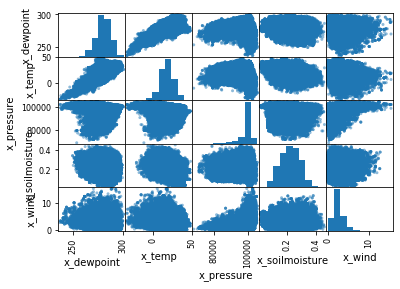

In [12]:
import matplotlib.pyplot as plt
#df[df.x_confirmed == True].plot.scatter(x="x_temp", y="x_soilmoisture")
#df[df.x_confirmed == True].plot.scatter(x="x_wind", y="x_soilmoisture")
pd.plotting.scatter_matrix(df[['x_dewpoint', 'x_temp', 'x_pressure', 'x_soilmoisture', 'x_wind', 'acq_time']])

In [3]:
# remove all uncertain events, leave all confirmed in
#print(len(df))
#df_conf = df[(df.confidence != 'l') | (df.x_confirmed == True)]
#df_conf = df_conf[(df_conf.confidence != 'n') | (df_conf.x_confirmed == True)]
#print(len(df))
df["confidence"] = df["confidence"].replace("l", '1')
df["confidence"] = df["confidence"].replace("n", '50')
df["confidence"] = df["confidence"].replace("h", '99').astype('int32')
print(len(df))
df_conf = df[(df.confidence > 60) | (df.x_confirmed == True)]
df_conf = df_conf[df_conf.x_landuse != "220"]

#print(len(df))
# remove all unconfirmed, HIGH confidence ones to leave only unconfirmed, low-confidence ones
#df_filtered = df[(                (df.confidence < 10 )         ) | (df.x_confirmed == True)]
len(df_conf)

#df = df[type(df.confidence) == "int" & df.confidence < '50']


632593


87409

In [5]:
print(len(df_conf))
c_conf = df_conf.dropna()
print(len(c_conf))

transform = make_column_transformer(
    (MinMaxScaler(), ['x_temp', 'x_pressure', 'x_soilmoisture', 'x_dewpoint', 'x_wind']),
    (OneHotEncoder(), ['x_landuse']),
)


87409
77865


In [7]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(c_conf, c_conf.x_confirmed, test_size=0.3)

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
model = make_pipeline(
    transform,
    SVC(probability=True))
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("SVC regression score: %f" % model.score(X_test, y_test))

print(classification_report(y_test, pred, target_names=['actually a fire', 'not sure']))

SVC regression score: 0.980950
                 precision    recall  f1-score   support

actually a fire       0.98      1.00      0.99     22915
       not sure       0.00      0.00      0.00       445

       accuracy                           0.98     23360
      macro avg       0.49      0.50      0.50     23360
   weighted avg       0.96      0.98      0.97     23360



/home/valli/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TBH this looks like overfitting. 😅Could be that the training data from only one year is not enough.

But, before we continue, we can try extracting the probabilities for a Germany-wide grid and see how the model behaves over a larger area. We first generate a regular grid, then query each point for it's fire probability and plot it using geopandas:

In [8]:
import datetime

def synth_fire(day, lat, lon):
  coords = [lon, lat]
  date_str = "2018-06-%02d 1500" % day
  dt = datetime.datetime.strptime(date_str, '%Y-%m-%d %H%M')

  fire = {"latitude": lat, "longitude": lon, "acq_date": "", "acq_time": "1500", "instrument": "", "x_confirmed": False, "frp": "", "x_wind_u": 0, "x_wind_v": 0}
  fire["x_temp"] = get_2m_temp(coords[1], coords[0], dt)
  fire["x_pressure"] = get_pressure(coords[1], coords[0], dt)
  fire["x_landuse"] = str(get_landuse(coords[1], coords[0]))
  fire["x_soilmoisture"] = get_soil_moisture(coords[1], coords[0], dt)
  fire["x_dewpoint"] = get_dewpoint(coords[1], coords[0], dt)
  fire["x_wind_u"] = get_wind_u(coords[1], coords[0], dt)
  fire["x_wind_v"] = get_wind_v(coords[1], coords[0], dt)
  fire["x_wind"] = math.sqrt(fire["x_wind_u"]**2 + fire["x_wind_v"]**2)

  return fire

#single_day = []
#for i in log_progress(range(100)):
#    for j in range(100):
#        single_day.append(synth_fire(25, 55.0-(j*0.1), 5.0 + (i*0.1)))

In [ ]:
#Remove lines with NaN values.

#import pandas as pd
#germany_pd = pd.DataFrame(juni)
#germany_pd = germany_pd[np.isfinite(germany_pd['latitude'])]
#preds = model.predict_proba(fail)
#grid = fail.insert(3, "fire_risk_inv", preds[:, 1])

#fail = pd.DataFrame(f).reindex_like(c)
#fail = fail.drop(fail.index[900:])
#fail = fail[np.isfinite(fail['x_soilmoisture'])]
#fail = fail[np.isfinite(fail['x_pressure'])]
#fail = fail[np.isfinite(fail['x_temp'])]
#fail = fail[np.isfinite(fail['x_dewpoint'])]
#fail = fail[np.isfinite(fail['x_wind'])]
#len(fail)
#fail = fail.dropna(subset=['x_landuse'])
#print(len(fail))
#germany_pd = germany_pd.reindex(columns=df.columns)
#print(len(fail))

#fail = fail[np.isfinite(fail['x_soilmoisture'])]
#fail = fail[np.isfinite(fail['x_pressure'])]
##fail = fail[np.isfinite(fail['x_temp'])]
#fail = fail[np.isfinite(fail['x_dewpoint'])]
#fail = fail[np.isfinite(fail['x_wind'])]
#fail
#fail[fail.x_landuse == ""]
#fail[np.isnan(fail.x_landuse)]
#valid = fail.x_landuse.unique()
#fail.x_landuse.unique()
#fail = fail.dropna(subset=['x_landuse'])
#fail = fail[fail.x_landuse != "220"]

In [32]:
#single_day_pd[c_conf.keys()]
#single_day_pd[single_day_pd.keys()]

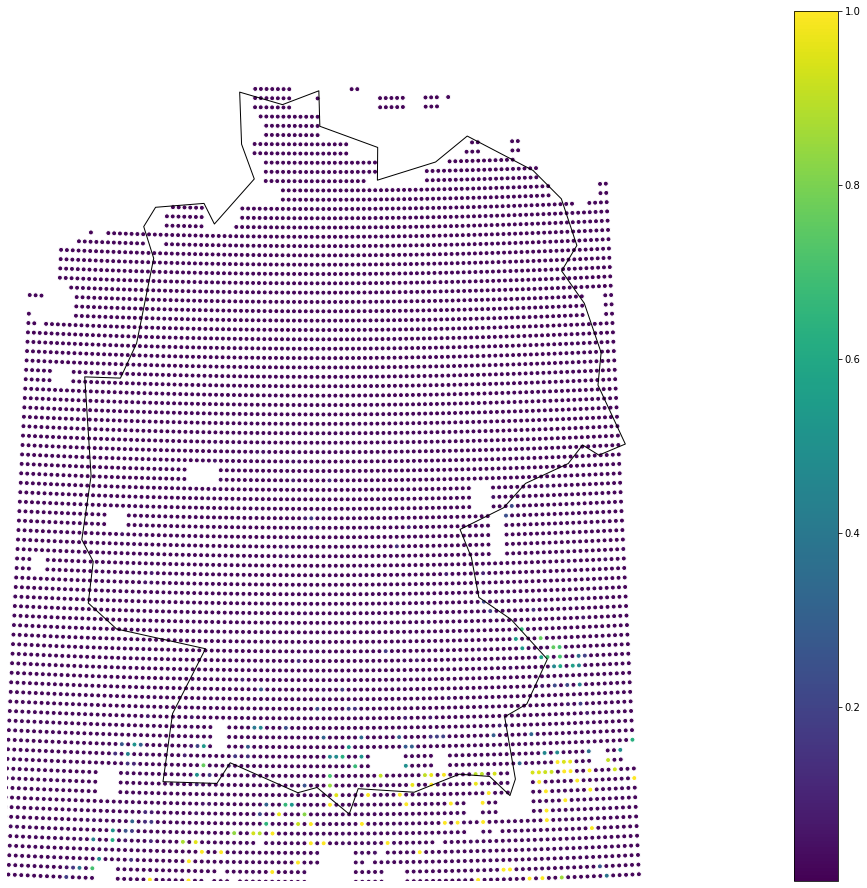

In [59]:
import geoplot
import geopandas
import geoplot.crs as gcrs
%matplotlib inline
import pandas as pd

single_day_pd = pd.DataFrame(single_day).assign(confidence=1)
single_day_pd = single_day_pd[np.isfinite(single_day_pd['latitude'])]
single_day_pd = single_day_pd[single_day_pd.x_landuse != "220"]
single_day_pd = single_day_pd.dropna()
single_day_pd_preds = model.predict_proba(single_day_pd[c_conf.keys()])
single_day_pd.insert(3, "fire_risk_inv", single_day_pd_preds[:, 1])

#gdf = geopandas.GeoDataFrame(single_day_grid, geometry=geopandas.points_from_xy(single_day_pd.longitude, single_day_pd.latitude))

world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

gdf = geopandas.GeoDataFrame(single_day_pd, geometry=geopandas.points_from_xy(single_day_pd.longitude, single_day_pd.latitude))

germany = world.query('name == "Germany"')

ax = geoplot.pointplot(
    gdf, cmap='viridis',
    projection=geoplot.crs.AlbersEqualArea(),
    hue="fire_risk_inv", legend=True, edgecolor='white', figsize=(32,16))

geoplot.polyplot(germany, ax=ax, zorder=1)

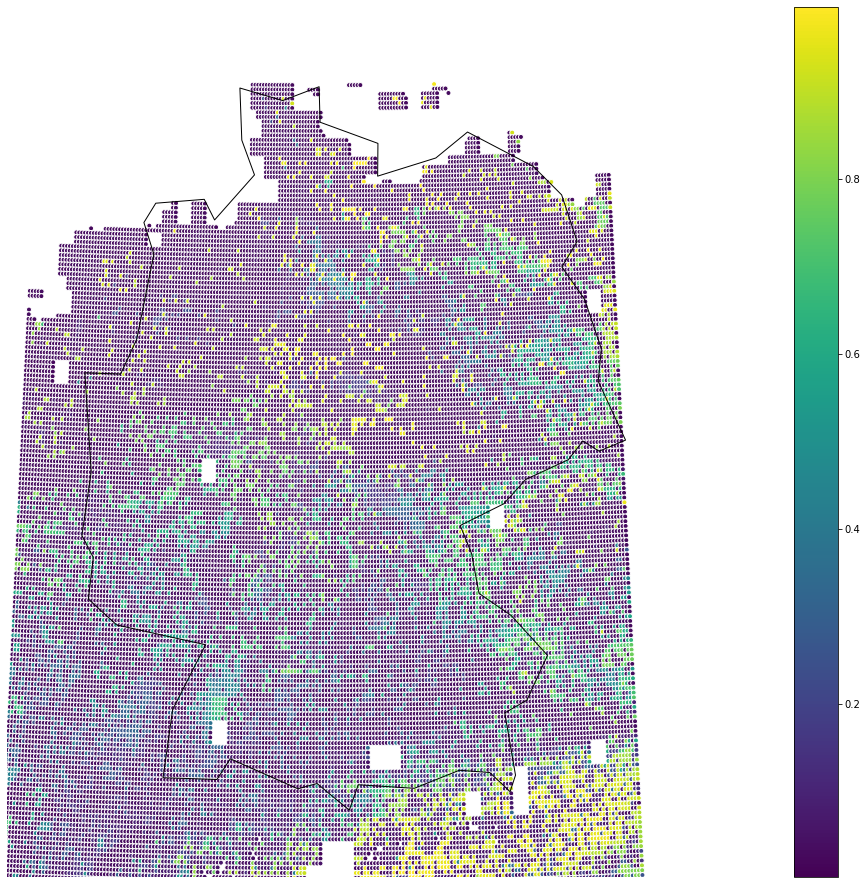

In [253]:
#africa = world.query('continent == "Europe"')
#ax = geoplot.cartogram(
#    gdf, scale='pop_est', limits=(0.2, 1),
#    edgecolor='None', figsize=(7, 8)
#)
#ax = geoplot.kdeplot(
#    gdf, shade=True, cmap='Reds', projection=geoplot.crs.AlbersEqualArea(),
#    hue='x_temp', clip=africa)


#ax = geoplot.voronoi(
#    gdf, cmap='viridis',
#    projection=geoplot.crs.AlbersEqualArea(),
#    clip=africa, hue="x_temp", legend=True, edgecolor='white')

#ax = geoplot.cartogram(
#    gdf, cmap='viridis',
#    projection=geoplot.crs.AlbersEqualArea(),
#    clip=africa, scale="x_temp", hue="x_soilmoisture" legend=True, edgecolor='white')

germany = world.query('name == "Germany"')

ax = geoplot.pointplot(
    gdf, cmap='viridis',
    projection=geoplot.crs.AlbersEqualArea(),
    hue="fire_risk_inv", legend=True, edgecolor='white', figsize=(32,16))

geoplot.polyplot(germany, ax=ax, zorder=1)

Interestingly, compared to the Fire Weather Index map from EFFIS. There are still lots of differences, but there is definitively some correlation in Central Germany and at the German/Czech border.

Erronous model response can be observed at the alps (which might be related to lots fires from the training data set being in mountains).

![wildfire risk](effis.png)

## FIRMS as positive events, random points as negative

Let's try something else: consider all (high confidence) fire detections from the satellite as positives. Negative set: random points sampled across entire Europe (probably without fires)

### Step 1: Generate hourly random grids and save to disk for later re-use

```
from multiprocessing import Process, Queue
from multiprocessing import Pool

def do_hour(hour):
  res = []
  for i in range(100):
    for j in range(100):
      #multidays.append(synth_fire(hour, 55.0-(j*0.1), 5.0 + (i*0.1)))
      res.append(synth_fire(hour, 63.782-(j*0.24), -14.019 + (i*0.6)))
  print("%d: %d" % (i, int(hour)))
  c = pd.DataFrame(res)
  #c['x_landuse'] = c['x_landuse'].apply(str)
  c.to_pickle("daily_eu_grid_%d.pickle" % hour)

pool = Pool(processes=48)
print(pool.map(do_hour, range(364*24)))
```

In [9]:
import glob
import pandas as pd

pickle_counter = 0
non_fires_list = []
for f in glob.glob("v7_daily_eu_grid_*"):
    pickle_counter += 1
    if pickle_counter % 1000 == 0:
        print(pickle_counter)
        pass
    non_fires_list.append(pd.read_pickle(f).drop(columns=["x_wind_v", "x_wind_u", "frp", "acq_date", "instrument", "x_confirmed", "x_biomass"]).dropna())
    #non_fires = pd.concat([non_fires, pd.read_pickle(f)])
    #print(f)
    #print(pd.read_pickle(f))
non_fires = pd.concat(non_fires_list).assign(fire=0)

1000
2000
3000
4000
5000
6000


In [78]:
#non_fires
non_fires.describe()
#pd.read_pickle("./v3_daily_eu_grid_1989.pickle").describe()

,latitude,longitude,x_temp,x_pressure,x_soilmoisture,x_dewpoint,x_wind,fire
count,4.931794e+06,4.931794e+06,4.931794e+06,4.931794e+06,4.931794e+06,4.931794e+06,4.931794e+06,4931794.0
mean,5.096145e+01,2.161995e+01,1.232921e+01,9.778899e+04,2.567766e-01,2.797270e+02,2.644935e+00,0.0
std,6.425428e+00,1.424818e+01,9.492783e+00,4.364632e+03,5.644615e-02,7.818511e+00,1.512155e+00,0.0
min,4.033300e+01,-9.518000e+00,-3.161318e+01,7.234855e+04,0.000000e+00,2.378443e+02,1.394877e-03,0.0
25%,4.577000e+01,1.003000e+01,5.478601e+00,9.693118e+04,2.225980e-01,2.748132e+02,1.566413e+00,0.0
50%,5.054300e+01,2.201800e+01,1.375540e+01,9.926869e+04,2.594120e-01,2.809648e+02,2.366601e+00,0.0
75%,5.593900e+01,3.399300e+01,1.943771e+01,1.003456e+05,2.928862e-01,2.857300e+02,3.454021e+00,0.0
max,6.378100e+01,4.453000e+01,4.028549e+01,1.043424e+05,7.179717e-01,3.001783e+02,2.044641e+01,0.0


In [81]:
actual_fires = df.assign(fire=1).drop(columns=["confidence", "frp"])
actual_fires = actual_fires[non_fires.keys()]
# 190 is city/urban -> filter it out because of steel works and the such
actual_fires = actual_fires[actual_fires.x_landuse != '190']
actual_fires.describe()

,latitude,longitude,x_temp,x_pressure,x_soilmoisture,x_dewpoint,x_wind,fire
count,487399.000000,487399.000000,468446.000000,468446.000000,433399.000000,468446.000000,468446.000000,487399.0
mean,47.719892,34.085583,19.217654,98837.991998,0.217406,279.519174,2.570470,1.0
std,6.907315,13.847809,8.460165,3853.293274,0.065258,7.091167,1.258257,0.0
min,33.516620,-10.446820,-32.937399,68448.289062,0.024736,237.201111,0.007432,1.0
25%,43.442050,26.782375,14.017023,98520.453125,0.167557,275.119904,1.784688,1.0
50%,47.994670,37.053550,19.138116,100015.015625,0.216115,279.744965,2.395869,1.0
75%,52.422900,43.848395,25.098047,100946.039062,0.267704,284.263123,3.122762,1.0
max,71.316510,57.310520,48.496362,105440.148438,0.456830,300.157257,15.367892,1.0


In [82]:
fires_and_nonfires = pd.concat([actual_fires, non_fires])
fires_and_nonfires['x_landuse'] = fires_and_nonfires['x_landuse'].apply(str)
fires_and_nonfires = fires_and_nonfires.dropna()
fires_and_nonfires = fires_and_nonfires.sample(frac=1)
fires_and_nonfires.describe()

,latitude,longitude,x_temp,x_pressure,x_soilmoisture,x_dewpoint,x_wind,fire
count,5.356811e+06,5.356811e+06,5.356811e+06,5.356811e+06,5.356811e+06,5.356811e+06,5.356811e+06,5.356811e+06
mean,5.070750e+01,2.270406e+01,1.288716e+01,9.786798e+04,2.536724e-01,2.797079e+02,2.634749e+00,7.934142e-02
std,6.501559e+00,1.457969e+01,9.579984e+00,4.332578e+03,5.814177e-02,7.744589e+00,1.487913e+00,2.702709e-01
min,3.357842e+01,-1.024188e+01,-3.161318e+01,7.135880e+04,0.000000e+00,2.378443e+02,1.394877e-03,0.000000e+00
25%,4.575200e+01,1.150700e+01,6.175653e+00,9.705525e+04,2.182313e-01,2.748517e+02,1.584167e+00,0.000000e+00
50%,4.997900e+01,2.350600e+01,1.427068e+01,9.932835e+04,2.571138e-01,2.808333e+02,2.367930e+00,0.000000e+00
75%,5.534700e+01,3.548200e+01,1.987710e+01,1.003939e+05,2.914528e-01,2.856319e+02,3.418522e+00,0.000000e+00
max,7.008075e+01,5.699260e+01,4.849636e+01,1.053293e+05,7.179717e-01,3.001783e+02,2.044641e+01,1.000000e+00


In [83]:
len(fires_and_nonfires)

5356811

In [ ]:
import pickle

august18 = []
for day in range(1,29):
    day_hours = []
    for i in log_progress(range(200)):
        for j in range(200):
            day_hours.append(synth_fire(day, 55.0-(j*0.05), 5.0 + (i*0.05)))
    august18.append(day_hours)

pickle.dump(august18, open("august2018.p", "wb"))

In [84]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(fires_and_nonfires, fires_and_nonfires.fire, test_size=0.3)

from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

transform2 = make_column_transformer(
    #(MinMaxScaler(), ['x_temp', 'x_pressure', 'x_soilmoisture', 'x_dewpoint', 'x_wind', 'acq_time']),
    (MinMaxScaler(), ['x_temp', 'x_pressure', 'x_soilmoisture', 'x_dewpoint', 'x_wind']),
    (OneHotEncoder(), ['x_landuse']),
)

svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 

model = make_pipeline(
    transform2,
    clf)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("SVC regression score: %f" % model.score(X_test, y_test))

print(classification_report(y_test, pred, target_names=['fire', 'no fire']))

SVC regression score: 0.925932
              precision    recall  f1-score   support

        fire       0.94      0.99      0.96   1479922
     no fire       0.59      0.21      0.31    127122

    accuracy                           0.93   1607044
   macro avg       0.76      0.60      0.64   1607044
weighted avg       0.91      0.93      0.91   1607044



In [88]:
import geoplot
import geopandas
import geoplot.crs as gcrs
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

plt.style.use('seaborn-white')

#rc('animation', html='html5')

%matplotlib inline
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

#for i in range(1,3):
def frame(i):
    print(i)
    i = i+1
    single_day_pd = pd.DataFrame(august18[i]).assign(confidence=1).assign(fire=1)
    single_day_pd = single_day_pd[np.isfinite(single_day_pd['latitude'])]
    single_day_pd = single_day_pd[single_day_pd.x_landuse != "220"]
    single_day_pd = single_day_pd.dropna()
    single_day_pd_preds = model.predict_proba(single_day_pd[fires_and_nonfires.keys()])
    single_day_pd.insert(3, "fire_risk_inv", single_day_pd_preds[:, 1])

    gdf = geopandas.GeoDataFrame(single_day_pd, geometry=geopandas.points_from_xy(single_day_pd.longitude, single_day_pd.latitude))

    germany = world.query('name == "Germany"')

    ax = geoplot.pointplot(
        gdf, cmap='viridis',
        projection=geoplot.crs.AlbersEqualArea(),
        hue="fire_risk_inv", legend=True, edgecolor='white',
        linewidth=0, figsize=(32,16))
    ax.set_title("2018-08-%d" % i)
    # scale="fire_risk_inv",

    plot = geoplot.polyplot(germany, ax=ax, zorder=1)
    #fig = plot.get_figure()

    #fig.savefig("plots/%d.png" % i)
    return plot
    
#fig, ax = plt.subplots()
#line, = ax.plot(x, y, color='k')

#for i in range(27):
#    frame(i).get_figure().savefig("plots/%02d.png" % i)

#import subprocess

#print(subprocess.run(["ffmpeg", "-framerate", "1", "-pattern_type", "glob", "-i", "'plots/*.png'", "-c:v", "libx264", "out_nocities.mp4"]))
    
#def update(num, x, y, line):
#    line.set_data(x[:num], y[:num])
#    line.axes.axis([0, 10, 0, 1])
#    return line,

#fig, ax = plt.subplots()
#ani = animation.FuncAnimation(fig, frame, 1, blit=False)
#ani.save("foo.mp4")

In [89]:
from IPython.display import HTML

#HTML("""
#<video width="320" height="240" controls>
#  <source src="out.mp4" type="video/mp4">
#</video>
#""")

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/jcobVZGcZ18" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')